In [10]:
pip install cvxopt

     |████████████████████████████████| 11.6 MB 137 kB/s eta 0:00:01    |███▌                            | 1.3 MB 3.9 MB/s eta 0:00:03     |█████▌                          | 2.0 MB 3.9 MB/s eta 0:00:03     |███████▍                        | 2.7 MB 3.9 MB/s eta 0:00:03     |████████▊                       | 3.1 MB 3.9 MB/s eta 0:00:03     |█████████████▏                  | 4.7 MB 3.9 MB/s eta 0:00:02     |████████████████▎               | 5.9 MB 3.9 MB/s eta 0:00:02     |███████████████████▎            | 7.0 MB 3.9 MB/s eta 0:00:02     |█████████████████████████       | 9.1 MB 3.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from cvxopt import matrix as cvmatrix
from cvxopt import solvers as cvsolvers
from sklearn.datasets import make_moons

In [23]:
def kernel(X1, X2, scale=1.0, sigmaf=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigmaf**2 * np.exp((-0.5 / scale**2) * sqdist)

In [24]:
def dataSt():
    X, y = make_moons(n_samples=100, noise=0.1) 
    y = np.where(y==0, -1, y)      
    y = y.reshape(-1,1)            
    S = (y>0).squeeze()            
    x_pos = X[S]                   
    x_neg = X[np.invert(S)]        
    return X,y,x_pos,x_neg

In [25]:
def dualOptimizer(H,m,y):
    H = H*1.0   
    y = y*1.0   
    P = cvmatrix(H) 
    q = cvmatrix(-np.ones((m, 1))) 
    G = cvmatrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvmatrix(np.hstack((np.zeros(m), np.ones(m) * 60)))
    A = cvmatrix(y.reshape(1, -1))  
    b = cvmatrix(np.zeros(1)) 
    
    cvsolvers.options['show_progress'] = False
    cvsolvers.options['abstol'] = 1e-10
    cvsolvers.options['reltol'] = 1e-10
    cvsolvers.options['feastol'] = 1e-10
    
    sol = cvsolvers.qp(P, q, G, h, A, b) 
    alphas = np.array(sol['x'])
    return alphas

In [26]:
def pred(y,a,X,p,b): 
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [27]:
np.random.seed(123)
X,y,x_pos,x_neg = dataSt()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape

alphas = dualOptimizer(H,m,y)
S = (alphas > 1e-4).flatten()
w = ((y[S] * alphas[S]).T @ X[S]).reshape(-1,1)
b = predb(y[S],alphas[S],X[S],X[S])

print('Alphas: ',alphas,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(10, 10) (1, 10)
Alphas:  [[8.08714920e-12]
 [7.90503393e-12]
 [5.88960773e-11]
 [7.46403312e-12]
 [4.93328796e-12]
 [6.00000000e+01]
 [6.86551836e-12]
 [5.67082353e-11]
 [6.40508807e-12]
 [1.02420446e-11]
 [1.86155115e-11]
 [9.07952248e-12]
 [2.00022474e-11]
 [4.89734188e-12]
 [1.20421887e-11]
 [1.76477562e-11]
 [6.00000000e+01]
 [5.20899342e-12]
 [5.88199943e-12]
 [6.25155041e-12]
 [3.96851154e-12]
 [1.24390653e-11]
 [7.71690589e-12]
 [5.95060372e-12]
 [5.45184672e+01]
 [7.48264950e-12]
 [9.24931952e-12]
 [5.77263777e-12]
 [4.30114347e-11]
 [7.71297820e-12]
 [2.27879026e-11]
 [1.27770813e-11]
 [6.28547686e-12]
 [1.35335480e-11]
 [4.73603929e-12]
 [1.03425191e-11]
 [7.26137149e-12]
 [1.10247645e-11]
 [9.41618250e-12]
 [7.13623979e-12]
 [9.14217671e-12]
 [6.44337414e-12]
 [4.16396830e-12]
 [6.46825445e-12]
 [1.98623220e+01]
 [9.70372637e-12]
 [5.95699940e-12]
 [6.01180728e-12]
 [6.34238027e-12]
 [1.14080161e-11]
 [1.13845038e-11]
 [7.77534650e-12]
 [6.00000000e+01]
 [1.08326878e-11]
 [

<a list of 4 text.Text objects>

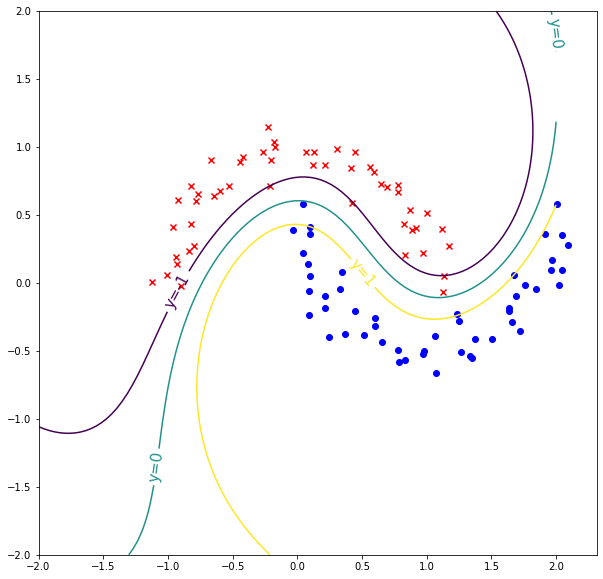

In [29]:
fig = plt.figure(figsize = (10,10))
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas[S],X[S],p,b)

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')

cp = plt.contour(x0, x1, pred(y[S],alphas[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)